Dessa vez, não consegui implementar uma animação, até porque o gráfico final é mais importante. Algoritmo incremental foi implementado

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Set

Point = Tuple[float, float]
Polygon = List[Point]

def dot(a: Point, b: Point) -> float:
    """Calcula o produto escalar de dois vetores 2D."""
    return a[0] * b[0] + a[1] * b[1]

def halfspace_p_closer_than_q(p: Point, q: Point) -> Tuple[Point, float]:
    """Retorna (n, c) definindo o meio-espaço n·x <= c para pontos mais próximos de p que de q."""
    vx, vy = q[0] - p[0], q[1] - p[1]
    n = (vx, vy)
    c = (q[0]**2 + q[1]**2 - p[0]**2 - p[1]**2) / 2
    return n, c

def clip_polygon(poly: Polygon, n: Point, c: float) -> Polygon:
    """Recorta um polígono convexo pelo meio-espaço n·x <= c."""
    if not poly:
        return []
    new_poly: Polygon = []
    m = len(poly)
    for i in range(m):
        A, B = poly[i], poly[(i + 1) % m]
        a_in = dot(n, A) <= c + 1e-9
        b_in = dot(n, B) <= c + 1e-9
        if a_in and b_in:
            new_poly.append(B)
        elif a_in and not b_in:
            t = (c - dot(n, A)) / dot(n, (B[0] - A[0], B[1] - A[1]))
            new_poly.append((A[0] + t * (B[0] - A[0]), A[1] + t * (B[1] - A[1])))
        elif not a_in and b_in:
            t = (c - dot(n, A)) / dot(n, (B[0] - A[0], B[1] - A[1]))
            inter = (A[0] + t * (B[0] - A[0]), A[1] + t * (B[1] - A[1]))
            new_poly.extend([inter, B])
    return new_poly

def incremental_voronoi(points: List[Point], bbox: Polygon) -> Dict[Point, Polygon]:
    """Calcula o diagrama de Voronoi incremental para um conjunto de pontos dentro de uma caixa delimitadora."""
    cells: Dict[Point, Polygon] = {}
    for p in points:
        cell = bbox.copy()
        for q in list(cells):
            n, c = halfspace_p_closer_than_q(p, q)
            cell = clip_polygon(cell, n, c)
            cells[q] = clip_polygon(cells[q], (-n[0], -n[1]), -c)
            if not cells[q]:
                del cells[q]
        cells[p] = cell
    return cells

def build_adjacency(vor: Dict[Point, Polygon]) -> Dict[Point, Set[Point]]:
    """Constroi a adjacência de vizinhança: pontos que compartilham uma aresta se suas células compartilharem pelo menos dois vértices."""
    adj: Dict[Point, Set[Point]] = {p: set() for p in vor}
    for p, poly_p in vor.items():
        verts_p = set(poly_p)
        for q, poly_q in vor.items():
            if p == q:
                continue
            common = verts_p.intersection(poly_q)
            if len(common) >= 2:
                adj[p].add(q)
    return adj

def run_voronoi(
    points: List[Point],
    print_final_graph: bool = True
) -> Dict[Point, Set[Point]]:
    """
    Constrói o diagrama de Voronoi, opcionalmente exibe o gráfico final,
    e retorna a lista de adjacência das células (vizinhos).

    O recorte é aplicado apenas dentro dos limites do plot (sem bordas infinitas).

    :param points: lista de tuplas (x, y)
    :param print_final_graph: se True, exibe o gráfico do diagrama
    :return: dicionário mapeando cada ponto ao seu conjunto de vizinhos
    """
    xs, ys = zip(*points)
    # Define bounding box igual a região de plotagem
    x_min, x_max = min(xs) - 1, max(xs) + 1
    y_min, y_max = min(ys) - 1, max(ys) + 1
    bbox = [
        (x_min, y_min),
        (x_max, y_min),
        (x_max, y_max),
        (x_min, y_max),
    ]
    vor = incremental_voronoi(points, bbox)

    if print_final_graph:
        fig, ax = plt.subplots()
        for poly in vor.values():
            if len(poly) < 3:
                continue
            cx = sum(x for x, _ in poly) / len(poly)
            cy = sum(y for _, y in poly) / len(poly)
            poly = sorted(poly, key=lambda p: math.atan2(p[1] - cy, p[0] - cx))
            xs_poly, ys_poly = zip(*(poly + [poly[0]]))
            ax.plot(xs_poly, ys_poly, linestyle='-', color='k')
        ax.scatter(xs, ys, c='red', zorder=3)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_aspect('equal')
        ax.set_title('Diagrama de Voronoi (incremental)')
        plt.show()
    # Representação textual das células
    for site, cell in vor.items():
        print(f"Point {site}: {cell}")
    return vor

# Para testar o algoritmo, mude a váriavel "pts" abaixo e rode o algoritmo. 
Se quiser apenas a representação textual, mude a variável "print_final_graph" para "False". Se quiser gerar pontos aleatórios, utilize a função "generate_random_points" como pode ser visto abaixo. Caso contrário, passe uma array de pontos no formato [(a,b), (c,d), (e,f), ... (y,z)]

In [60]:
import random
random.seed(42)
def generate_random_points(num_points, l=10):
    """o parâmetro l determina o limite dos valores de x e y para os quais serão gerados os pontos"""
    return [(random.uniform(-l, l), random.uniform(-l, l)) for _ in range(num_points)]

O print das regiões ficou limitado ao limite do grafico. Portanto, as caixas que estão "limitadas" pelos limites do gráfico em plaintext na verdade se estendem para o infinito

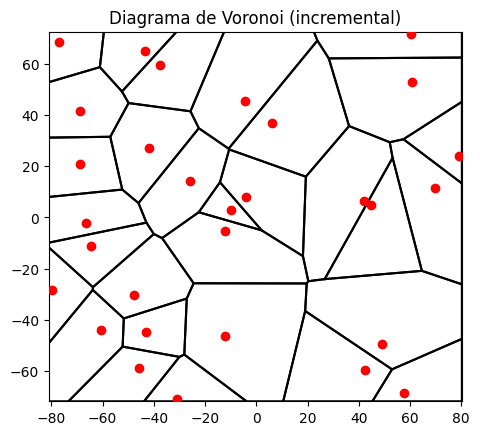

Point (42.0017280120242, 6.300644819140118): [(53.19955403258111, 23.271361268458516), (52.08303882131068, 29.371683001394317), (36.21273294880651, 35.68160615699809), (19.34228557528859, 15.919382355787935), (18.21699482919668, -15.085799696240603), (20.307299390114558, -24.877489583964948), (26.695681157956816, -24.05395250816143)]
Point (44.58023658088932, 4.856587551228401): [(26.69568115795682, -24.053952508161416), (64.63782709774928, -20.831626975841818), (53.199554032581105, 23.2713612684585)]
Point (-79.90849661952905, -28.135030879252305): [(-80.90849661952905, -48.96890411083124), (-63.808363415001544, -28.262742114741172), (-63.74287276325216, -27.20676881877055), (-80.90849661952905, -11.733089012496418)]
Point (-76.88372121826683, 68.65577860233873): [(-59.47647179498849, 72.51191124767905), (-80.90849661952905, 72.51191124767905), (-80.90849661952905, 52.81359660889026), (-61.040281618137755, 58.67817765235609)]
Point (60.59550045170948, 53.066484697788724): [(80.2238970

In [63]:
# MUDE apenas ESSAS VARIÁVEIS
points = generate_random_points(30, 80)
print_final_graph = True

if __name__ == '__main__':
    diagram = run_voronoi(points, print_final_graph=print_final_graph)